<a href="https://colab.research.google.com/github/Ares9505/IA-projects/blob/main/Practica2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Importando librerias de openCv
import cv2
from google.colab.patches import cv2_imshow
!pip install cvzone
!pip install mediapipe
from cvzone.HandTrackingModule import HandDetector

#Librerias de scikit-learn
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report

base_dir = '/content/drive/My Drive/Ciencia de datos practica 2/practica2/Dataset sensores/'

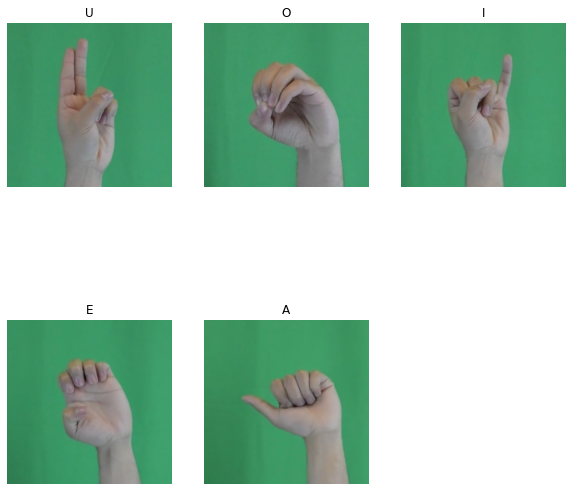

In [3]:
#Mostrando las señas y su significado
def show_sings(base_dir):
  images = []
  folders = os.listdir(base_dir + 'S10') 
  img_size = 64
  plt.figure(figsize=(10, 10))
  for i,folder in enumerate(folders):
    i_path = base_dir + 'S10/' + folder
    file_name = os.listdir(i_path)[0]
    file_path = os.path.join(i_path, file_name)
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img)
    plt.subplot(2, 3, i + 1)
    plt.axis('off')  
    plt.imshow(img)
    plt.title(folder)

show_sings(base_dir)

In [4]:
#Funcion para extraer features

img_path = '/content/drive/My Drive/Ciencia de datos practica 2/practica2/Dataset sensores/S10/O/O-3-52.jpg'

def extract_features(img_path):
  img = cv2.imread(img_path)
  detector = HandDetector(detectionCon=0.2, maxHands=2)
  hands, img = detector.findHands(img) 
  #cv2_imshow(img)
  if len(hands) != 0:
    hand = hands[0] #mano detectada
    #21 puntos de referencia(landmark)
    lm_list = []
    lmhand = hand["lmList"]
    for lm in lmhand:
      lm_list.extend(lm)
    #Información del cuadro delimitador 
    bbox = list(hand['bbox'])
    #Centro de la mano
    centerPoint = list(hand['center'])
    #mano izquierda o derecha
    handtype = 1 if hand['type'] == "Left" else 0
    #Dedos levantados
    fingers = detector.fingersUp(hand)
    features = []
    for feature in [lm_list, bbox, centerPoint,[handtype],fingers]:
      features.extend(feature)
  
    return features
  else:
    return None

#descomentar para probar funcion extract features
#print(extract_features(img_path))


In [5]:
#Extraccion de features por lotes para cada grupo

carpetas = os.listdir(base_dir) #aqui cada carpeta representa un grupo(persona)

#Las imagenes seran procesadas por lotes de grupos
#Para evitar uso excesivo de ram y no se quede se reinicie la sesion en colab
def process_batch(base_dir,carpetas,a,b,val = False):
  dataset = pd.DataFrame(columns = [*[i for i in range(75)], 'letra', 'Grupo'])
  path_desechados = [] # manos desechadas
  for index in range(a,b):
    grupo = carpetas[index]
    path = base_dir + grupo
    for root, dirs, files in os.walk(path):
      for file in files:
        if file.endswith(".jpg"):
          file_path = os.path.join(root,file)       
          features = extract_features(file_path)
          if features:
            letra = os.path.basename(root)
            if val:
              letra = file.split(".")[0]
            dataset = dataset.append(
                pd.Series([*features,letra,grupo], index=dataset.columns),
                ignore_index=True
                )
          else:
            path_desechados.append(file_path)
  return dataset,path_desechados



In [ ]:
#Lote 1
dataset,path_desechados = process_batch(base_dir,carpetas,0,3)
dataset.to_csv('/content/drive/My Drive/Ciencia de datos practica 2/practica2/dataset1.csv', index=False)
print(path_desechados)

In [4]:
#Lote 2
dataset,path_desechados = process_batch(base_dir,carpetas,3,6)
dataset.to_csv('/content/drive/My Drive/Ciencia de datos practica 2/practica2/dataset2.csv', index=False)
print(path_desechados)

[]


In [5]:
#Lote 3
dataset,path_desechados = process_batch(base_dir,carpetas,6,9)
dataset.to_csv('/content/drive/My Drive/Ciencia de datos practica 2/practica2/dataset3.csv', index=False)
print(path_desechados)

[]


In [4]:
#Lote 4
dataset,path_desechados = process_batch(base_dir,carpetas,9,10)
dataset.to_csv('/content/drive/My Drive/Ciencia de datos practica 2/practica2/dataset4.csv', index=False)
print(path_desechados)


[]


In [4]:
#Cargando y uniendo lotes de datasets en uno solo
df= pd.read_csv(f'/content/drive/My Drive/Ciencia de datos practica 2/practica2/dataset1.csv')
for i in range(2,5):
  df_temp = pd.read_csv(f'/content/drive/My Drive/Ciencia de datos practica 2/practica2/dataset{i}.csv')
  df =pd.concat([df,df_temp])

df.to_csv('/content/drive/My Drive/Ciencia de datos practica 2/practica2/dataset_entero.csv', index=False)

In [6]:
df_path = '/content/drive/My Drive/Ciencia de datos practica 2/practica2/dataset_entero.csv'
df = pd.read_csv(df_path)

Grupo: ['S10' 'S7' 'S8' 'S2' 'S4' 'S1' 'S3' 'S6' 'S5' 'S9']
Scores: [0.9, 0.8775510204081632, 0.9, 0.94, 0.96, 0.82, 0.86, 0.78, 0.9, 0.9]


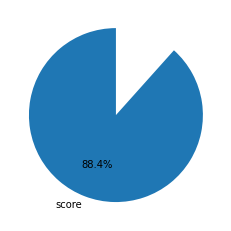

In [29]:
# Creacion y entrenameinto del modelo
grupos = df['Grupo'].unique()
scores = []

nb = GaussianNB()

#Implementacion de leave one out
for grupo in grupos:
  df_train = df[df.Grupo != grupo]
  X_train = df_train.iloc[: ,:-2].values
  Y_train = df_train['letra'].values

  df_test = df[df.Grupo == grupo]
  X_test = df_test.iloc[: ,:-2].values
  Y_test = df_test['letra'].values 

  # Crear un clasificador Naive Bayes y ajustarlo a los datos de entrenamiento
  nb.fit(X_train, Y_train)

  # Realizar predicciones en los datos de prueba
  y_pred = nb.predict(X_test)

  scores.append( nb.score(X_test,Y_test))

print(f'Grupo: {grupos}')
print(f'Scores: {scores}')
fig, ax = plt.subplots()
ax.pie([np.mean(scores)], labels=["score"], autopct='%1.1f%%', startangle=90)
plt.show()

In [35]:
#redimensionar imagenes capturadas
#este codigo solo se uso una vez para que las img tuvieran las mismas
#dimensiones que las de entrenamiento
val_dir = '/content/drive/My Drive/Ciencia de datos practica 2/practica2/Validacion/'
for root,dirs,files in os.walk(val_dir):
  for file in files:
    path = os.path.join(root,file)
    img = cv2.imread(path)
    img_rs = cv2.resize(img,(300,300))
    cv2.imwrite(path,img_rs)

In [24]:
#Validación
val_dir = '/content/drive/My Drive/Ciencia de datos practica 2/practica2/Validacion/'
dir = os.listdir(val_dir)
df_val,_ = process_batch(val_dir,dir,0,3,val=True)
x_val = df_val.iloc[: ,:-2].values
y_val = df_val['letra'].values

y_pred = nb.predict(x_val)
print(f'True values:     {y_val}')
print(f'Predicted values:{y_pred}')
nb.score(x_val,y_val)



True values:     ['A' 'U' 'E' 'O' 'I' 'A' 'U' 'O' 'I' 'E' 'I' 'E' 'O' 'U' 'A']
Predicted values:['O' 'U' 'E' 'O' 'I' 'O' 'U' 'O' 'O' 'E' 'I' 'O' 'O' 'U' 'A']


0.7333333333333333

              precision    recall  f1-score   support

           A       1.00      0.33      0.50         3
           E       1.00      0.67      0.80         3
           I       1.00      0.67      0.80         3
           O       0.43      1.00      0.60         3
           U       1.00      1.00      1.00         3

    accuracy                           0.73        15
   macro avg       0.89      0.73      0.74        15
weighted avg       0.89      0.73      0.74        15



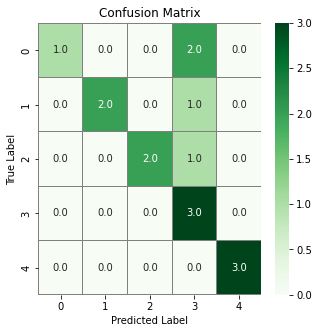

In [25]:
# Desempeño del modelo
cm = confusion_matrix(y_val, y_pred)
cr = classification_report(y_val, y_pred)
print(cr)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, linewidths=0.01, cmap="Greens", linecolor="gray", fmt=".1f", ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()